In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
import os
from datetime import timedelta
import plotly.express as px


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv('final_features.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head(3)

,Block,Tavg,Depart,DewPoint,Heat,Cool,water_equiv_snowfall,station_pressure,wind_direction,avg_wind_speed,wind_direction_cos,wind_direction_sin,TS,FG,BR,VC,MD,spray_dist,station_dist,station_lat_diff,pre_has_spray,population,median_income,population_density,RH_avg,Tavg_1,DewPoint_1,Heat_1,water_equiv_snowfall_1,station_pressure_1,wind_direction_1,avg_wind_speed_1,wind_direction_cos_1,wind_direction_sin_1,TS_1,RA_1,FG_1,BR_1,HZ_1,MD_1,RH_avg_1,Tavg_2,Depart_2,DewPoint_2,Heat_2,water_equiv_snowfall_2,station_pressure_2,wind_direction_2,avg_wind_speed_2,wind_direction_cos_2,wind_direction_sin_2,TS_2,DZ_2,FG_2,VC_2,RH_avg_2,Tavg_3,Depart_3,DewPoint_3,Heat_3,Cool_3,water_equiv_snowfall_3,station_pressure_3,wind_direction_3,avg_wind_speed_3,wind_direction_cos_3,wind_direction_sin_3,TS_3,DZ_3,BR_3,MD_3,RH_avg_3,density,NumMosquitos_lag,year,Street,Species,month,day_of_year,WnvPresent
0,41,74.0,10.0,58,0.0,9.0,0.0,29.39,180,6.5,-1.0,1.224647e-16,0,0,1,0,0,1.414,0.138026,-0.040310,0,75604,55324.0,10611.96,642.111618,65.0,47,0.0,0.0,29.43,100,5.3,-0.173648,0.984808,0,1,0,0,0,0,507.550736,66.0,4.0,47,0.0,0.04,29.34,260,9.5,-0.173648,-0.984808,0,0,0,0,490.379949,57.0,-5.0,55,8.0,0.0,1.01,29.36,170,7.2,-0.984808,0.173648,1,0,1,0,999.126784,0.0,27.0,2007,31,2,5,149,0
1,41,74.0,10.0,58,0.0,9.0,0.0,29.39,180,6.5,-1.0,1.224647e-16,0,0,1,0,0,1.414,0.138026,-0.040310,0,75604,55324.0,10611.96,642.111618,65.0,47,0.0,0.0,29.43,100,5.3,-0.173648,0.984808,0,1,0,0,0,0,507.550736,66.0,4.0,47,0.0,0.04,29.34,260,9.5,-0.173648,-0.984808,0,0,0,0,490.379949,57.0,-5.0,55,8.0,0.0,1.01,29.36,170,7.2,-0.984808,0.173648,1,0,1,0,999.126784,0.0,27.0,2007,31,3,5,149,0
2,62,74.0,10.0,58,0.0,9.0,0.0,29.39,180,6.5,-1.0,1.224647e-16,0,0,1,0,0,1.414,0.163721,-0.000009,0,29043,72086.0,5741.46,642.111618,65.0,47,0.0,0.0,29.43,100,5.3,-0.173648,0.984808,0,1,0,0,0,0,507.550736,66.0,4.0,47,0.0,0.04,29.34,260,9.5,-0.173648,-0.984808,0,0,0,0,490.379949,57.0,-5.0,55,8.0,0.0,1.01,29.36,170,7.2,-0.984808,0.173648,1,0,1,0,999.126784,0.0,3.0,2007,26,3,5,149,0


In [3]:
data['WnvPresent'].sum()

551

Our dataset is very unbalanced. one can do oversampling.

In [4]:
y = data['WnvPresent']

X = data.drop(columns=['WnvPresent'])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91, stratify=y.values)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [6]:
def oversample(X, y):
    num_samples = 5000
    a, b = X.loc[y.values==0, :].copy(), X.loc[y.values==1, :].copy()
    sample_a = a.sample(num_samples, replace=True, random_state=41)
    sample_b = b.sample(num_samples, replace=True, random_state=41)
    y_a = np.zeros(num_samples)
    y_b = np.ones(num_samples)
    return pd.concat([sample_a, sample_b]), np.concatenate([y_a, y_b])

def undersample(X, y):
    a, b = X.loc[y.values==0, :].copy(), X.loc[y.values==1, :].copy()
    a_size = b.shape[0]
    sample_a = a.sample(a_size, replace=True, random_state=41)
    y_a = np.zeros(a_size)
    y_b = np.ones(a_size)
    return pd.concat([sample_a, b]), np.concatenate([y_a, y_b])

In [7]:
X_train.head()

,Block,Tavg,Depart,DewPoint,Heat,Cool,water_equiv_snowfall,station_pressure,wind_direction,avg_wind_speed,wind_direction_cos,wind_direction_sin,TS,FG,BR,VC,MD,spray_dist,station_dist,station_lat_diff,pre_has_spray,population,median_income,population_density,RH_avg,Tavg_1,DewPoint_1,Heat_1,water_equiv_snowfall_1,station_pressure_1,wind_direction_1,avg_wind_speed_1,wind_direction_cos_1,wind_direction_sin_1,TS_1,RA_1,FG_1,BR_1,HZ_1,MD_1,RH_avg_1,Tavg_2,Depart_2,DewPoint_2,Heat_2,water_equiv_snowfall_2,station_pressure_2,wind_direction_2,avg_wind_speed_2,wind_direction_cos_2,wind_direction_sin_2,TS_2,DZ_2,FG_2,VC_2,RH_avg_2,Tavg_3,Depart_3,DewPoint_3,Heat_3,Cool_3,water_equiv_snowfall_3,station_pressure_3,wind_direction_3,avg_wind_speed_3,wind_direction_cos_3,wind_direction_sin_3,TS_3,DZ_3,BR_3,MD_3,RH_avg_3,density,NumMosquitos_lag,year,Street,Species,month,day_of_year
0,45,81.0,8.0,62,0.0,16.0,0.0,29.29,90,4.1,6.123234e-17,1.000000,0,0,0,0,0,1.414000,0.243177,-0.031024,0,78820,57252.0,23681.910,615.828276,79.0,60,0.0,0.00,29.39,70,5.0,0.34202,9.396926e-01,0,0,0,0,0,1,598.746707,76.0,2.0,57,0.0,0.00,29.39,60,4.6,0.500000,0.866025,0,0,0,0,573.299205,76.0,0.0,56,0.0,11.0,0.00,29.34,50,6.9,0.642788,0.766044,0,0,0,1,546.584719,0.0,2.0,2007,15,2,8,213
1,53,79.0,18.0,63,0.0,14.0,0.0,29.27,190,11.9,-9.848078e-01,-0.173648,0,0,0,0,1,1.414000,0.337807,-0.103874,0,33937,85074.0,17783.870,687.688535,69.0,50,0.0,0.00,29.49,120,6.4,-0.50000,8.660254e-01,0,0,0,0,0,1,514.905290,65.0,1.0,45,0.0,0.00,29.48,10,7.7,0.984808,0.173648,0,0,0,0,458.106189,79.0,14.0,59,0.0,14.0,0.00,29.23,220,11.5,-0.766044,-0.642788,0,0,0,0,571.384082,0.0,3.0,2007,41,6,9,267
2,11,78.0,8.0,64,0.0,13.0,0.0,29.29,100,4.7,-1.736482e-01,0.984808,0,0,1,0,0,0.082283,0.294789,-0.098718,0,20191,70188.0,56.465,743.499173,77.0,67,0.0,0.00,29.32,360,8.7,1.00000,-2.449294e-16,0,0,0,1,0,0,879.109602,87.0,17.0,68,0.0,0.00,29.24,240,12.7,-0.500000,-0.866025,0,0,0,0,667.529966,81.0,11.0,66,0.0,16.0,0.00,29.41,230,9.5,-0.642788,-0.766044,0,0,0,1,738.514318,0.0,2.0,2013,107,1,8,241
3,35,70.0,10.0,56,0.0,5.0,0.0,29.39,170,5.9,-9.848078e-01,0.173648,0,0,0,0,0,1.414000,0.042741,0.014737,0,86715,38196.0,12507.780,667.361303,65.0,47,0.0,0.00,29.34,250,7.1,-0.34202,-9.396926e-01,0,0,0,0,0,1,507.550736,70.0,10.0,59,0.0,0.11,29.25,190,10.3,-0.984808,-0.173648,0,0,0,0,769.344782,64.0,6.0,59,1.0,0.0,0.17,29.35,210,8.9,-0.866025,-0.500000,0,0,1,0,944.490971,0.0,5.0,2007,92,2,10,277
4,58,71.0,7.0,55,0.0,6.0,0.0,29.34,330,2.1,8.660254e-01,-0.500000,0,0,0,0,1,1.414000,0.243356,-0.008079,0,78820,57252.0,23681.910,615.014221,68.0,55,0.0,0.01,29.45,70,4.2,0.34202,9.396926e-01,0,0,1,1,0,0,680.647499,70.0,4.0,61,0.0,0.00,29.47,60,4.5,0.500000,0.866025,0,0,1,0,844.534537,71.0,6.0,59,0.0,6.0,0.00,29.49,80,6.7,0.173648,0.984808,0,0,1,0,743.888824,0.0,6.0,2009,43,3,9,257


In [8]:
resample_X_train, resample_y_train = oversample(X_train, y_train)

In [9]:
undersample_X_train, undersample_y_train = undersample(X_train, y_train)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression


rf = RandomForestClassifier(n_estimators=400, oob_score=True)


param = {'criterion':['gini', 'entropy'], 'max_depth':[16, 32, 64], 'min_samples_leaf':[2,4,8],
         'min_samples_split':[2,4,8], 'class_weight':[{0:1,1:2}, {0:1,1:4}, {0:1,1:1}]}

grid = GridSearchCV(rf, param, scoring='balanced_accuracy')



In [45]:
grid.fit(undersample_X_train, undersample_y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=400, oob_score=True),
             param_grid={'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 4},
                                          {0: 1, 1: 1}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 32, 64],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 4, 8]},
             scoring='balanced_accuracy')

In [46]:
grid.best_params_

{'class_weight': {0: 1, 1: 1},
 'criterion': 'entropy',
 'max_depth': 32,
 'min_samples_leaf': 2,
 'min_samples_split': 8}

In [47]:
best_rf = grid.best_estimator_

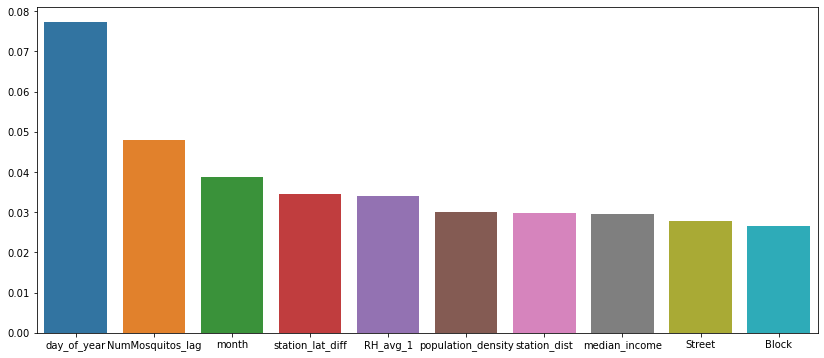

In [48]:
best_rf.fit(undersample_X_train, undersample_y_train)

f_importance = pd.Series(index=undersample_X_train.columns.values, data = best_rf.feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [49]:
y_pred = best_rf.predict(X_test)

In [50]:
cm = confusion_matrix(y_test.values, y_pred, labels=[0,1], normalize='pred')
print(cm)

print(classification_report(y_test.values, y_pred))

[[1448  544]
 [  16   94]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1992
           1       0.15      0.85      0.25       110

    accuracy                           0.73      2102
   macro avg       0.57      0.79      0.54      2102
weighted avg       0.95      0.73      0.81      2102



In [51]:
lg = LGBMClassifier()


param = {'max_depth':[12, 16, 20] ,'learning_rate':[0.05, 0.1, 0.2], 'n_estimators':[400, 800], 
        'min_child_samples':[2, 4, 8], 'scale_pos_weight':[1,2,4]}

grid = GridSearchCV(lg, param, scoring = 'balanced_accuracy')

In [52]:
grid.fit(undersample_X_train, undersample_y_train)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [12, 16, 20],
                         'min_child_samples': [2, 4, 8],
                         'n_estimators': [400, 800],
                         'scale_pos_weight': [1, 2, 4]},
             scoring='balanced_accuracy')

In [53]:
grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 12,
 'min_child_samples': 2,
 'n_estimators': 400,
 'scale_pos_weight': 2}

In [54]:
best_lgbm = grid.best_estimator_

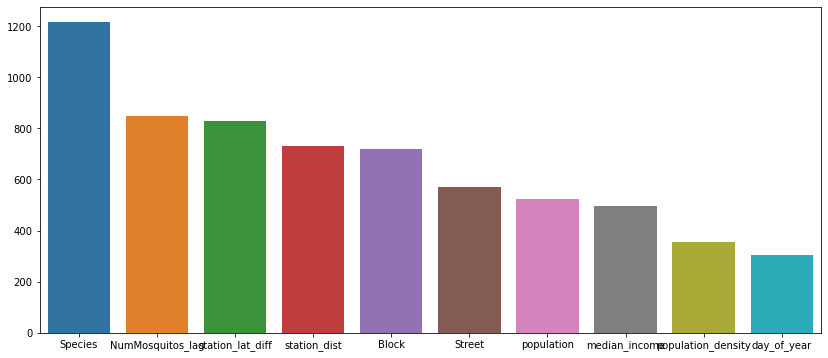

In [55]:
best_lgbm.fit(undersample_X_train, undersample_y_train)

f_importance = pd.Series(index=undersample_X_train.columns.values, data = best_lgbm.feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [56]:
y_pred = best_lgbm.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1], normalize='pred')
print(cm)

print(classification_report(y_test.values, y_pred))

[[1392  600]
 [  16   94]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1992
           1       0.14      0.85      0.23       110

    accuracy                           0.71      2102
   macro avg       0.56      0.78      0.53      2102
weighted avg       0.94      0.71      0.79      2102



In [38]:
log_reg = LogisticRegression(max_iter=500)
power = PowerTransformer()

pipe = Pipeline([('p', power), ('log_reg', log_reg)])

param = {'log_reg__C':[4,8,16], 'log_reg__class_weight':[{0:1,1:1}, {0:1, 1:2}, {0:1, 1:4}]}

grid = GridSearchCV(pipe, param, scoring = 'balanced_accuracy')

In [39]:
grid.fit(undersample_X_train, undersample_y_train)

C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:325

GridSearchCV(estimator=Pipeline(steps=[('p', PowerTransformer()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'log_reg__C': [4, 8, 16],
                         'log_reg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                                   {0: 1, 1: 4}]},
             scoring='balanced_accuracy')

In [40]:
grid.best_params_

{'log_reg__C': 4, 'log_reg__class_weight': {0: 1, 1: 2}}

In [41]:
best_log_reg = grid.best_estimator_

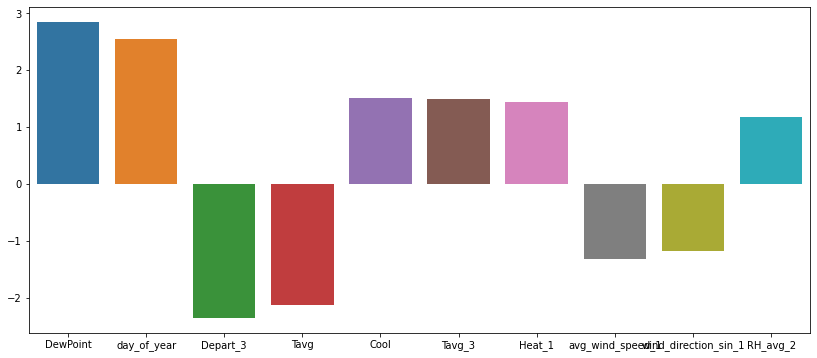

In [42]:
best_log_reg.fit(undersample_X_train, undersample_y_train)

f_importance = pd.Series(index=undersample_X_train.columns.values, data = best_log_reg.get_params()['log_reg'].coef_[0,:])

abs_f_importance = np.abs(f_importance).sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=abs_f_importance.index[:10], y=f_importance[abs_f_importance.index[:10]])
plt.show()

In [43]:
y_pred = best_log_reg.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1], normalize='pred')
print(cm)

print(classification_report(y_test.values, y_pred))

[[1158  834]
 [   8  102]]
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      1992
           1       0.11      0.93      0.20       110

    accuracy                           0.60      2102
   macro avg       0.55      0.75      0.46      2102
weighted avg       0.95      0.60      0.71      2102



In [11]:
from sklearn.ensemble import StackingClassifier


pipe = Pipeline([('p', PowerTransformer()), ('log_reg', LogisticRegression(max_iter=500, C=4, class_weight={0:1, 1:2}))])

estimators = [('lgbm', 
               LGBMClassifier(learning_rate=0.05, max_depth=12, scale_pos_weight=2, n_estimators=400, min_child_samples=2)),
             ('pipe', pipe)]


final = StackingClassifier(estimators = estimators)

final.fit(undersample_X_train, undersample_y_train)

C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(learning_rate=0.05, max_depth=12,
                                               min_child_samples=2,
                                               n_estimators=400,
                                               scale_pos_weight=2)),
                               ('pipe',
                                Pipeline(steps=[('p', PowerTransformer()),
                                                ('log_reg',
                                                 LogisticRegression(C=4,
                                                                    class_weight={0: 1,
                                                                                  1: 2},
                                                                    max_iter=500))]))])

In [12]:
y_pred = final.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1], normalize='pred')
print(cm)

print(classification_report(y_test.values, y_pred))

[[0.99008499 0.86086957]
 [0.00991501 0.13913043]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1992
           1       0.14      0.87      0.24       110

    accuracy                           0.71      2102
   macro avg       0.56      0.79      0.53      2102
weighted avg       0.95      0.71      0.79      2102



In [13]:
rf = RandomForestClassifier(n_estimators=400)



param = {'criterion':['gini', 'entropy'], 'max_depth':[16, 32, 64], 'min_samples_leaf':[2,4,8],
         'min_samples_split':[2,4,8], 'class_weight':[{0:1, 1:1}, {0:1, 1:2}]}

grid = GridSearchCV(rf, param, scoring='balanced_accuracy')


In [14]:
grid.fit(resample_X_train, resample_y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=400),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 32, 64],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 4, 8]},
             scoring='balanced_accuracy')

In [15]:
grid.best_params_

{'class_weight': {0: 1, 1: 1},
 'criterion': 'entropy',
 'max_depth': 64,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [16]:
best_rf = grid.best_estimator_

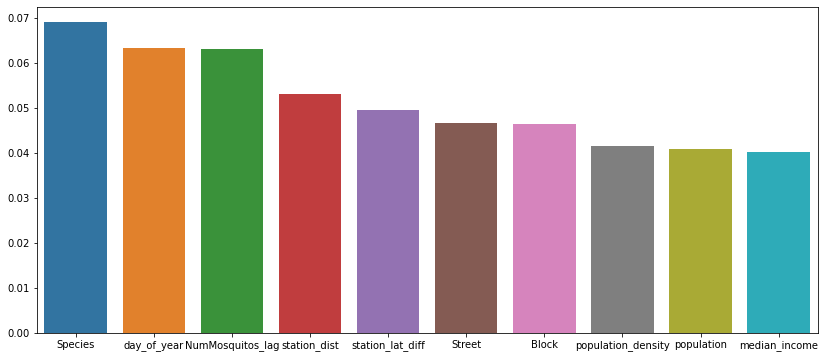

In [17]:
best_rf.fit(resample_X_train, resample_y_train)

f_importance = pd.Series(index=resample_X_train.columns.values, data = best_rf.feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [18]:
y_pred = best_rf.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1], normalize='pred')
print(cm)

print(classification_report(y_test.values, y_pred))

[[0.96811435 0.81625442]
 [0.03188565 0.18374558]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1992
           1       0.18      0.47      0.26       110

    accuracy                           0.86      2102
   macro avg       0.58      0.68      0.59      2102
weighted avg       0.93      0.86      0.89      2102



In [19]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()


param = {'max_depth':[12, 16, 20] ,'learning_rate':[0.05, 0.1,0.2,0.4], 'n_estimators':[400, 600], 
        'min_child_samples':[2,4,6],'scale_pos_weight':[1,2]}

grid = GridSearchCV(lgbm, param, scoring='balanced_accuracy')

In [20]:
grid.fit(resample_X_train, resample_y_train)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.4],
                         'max_depth': [12, 16, 20],
                         'min_child_samples': [2, 4, 6],
                         'n_estimators': [400, 600],
                         'scale_pos_weight': [1, 2]},
             scoring='balanced_accuracy')

In [21]:
grid.best_params_

{'learning_rate': 0.2,
 'max_depth': 16,
 'min_child_samples': 2,
 'n_estimators': 600,
 'scale_pos_weight': 1}

In [22]:
best_lgbm = grid.best_estimator_

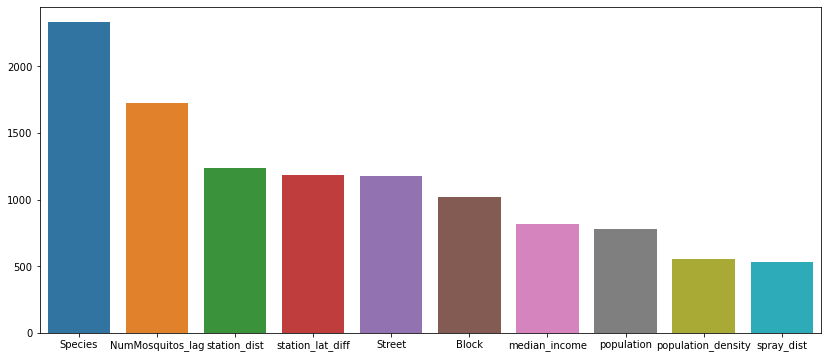

In [23]:
best_lgbm.fit(resample_X_train, resample_y_train)

f_importance = pd.Series(index=resample_X_train.columns.values, data = best_lgbm.feature_importances_)

f_importance = f_importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=f_importance.index[:10], y=f_importance.values[:10])
plt.show()

In [24]:
y_pred = best_lgbm.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1], normalize='pred')
print(cm)

print(classification_report(y_test.values, y_pred))

[[0.96493092 0.8       ]
 [0.03506908 0.2       ]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1992
           1       0.20      0.40      0.27       110

    accuracy                           0.88      2102
   macro avg       0.58      0.66      0.60      2102
weighted avg       0.92      0.88      0.90      2102



In [25]:
log_reg = LogisticRegression(max_iter=500)
power = PowerTransformer()

pipe = Pipeline([('p', power), ('log_reg', log_reg)])

param = {'log_reg__C':[4,8,16], 'log_reg__class_weight':[{0:1,1:1}, {0:1, 1:2}]}

grid = GridSearchCV(pipe, param, scoring = 'balanced_accuracy')

In [26]:
grid.fit(resample_X_train, resample_y_train)

C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:325

C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\folderconda\envs\new_env\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\folderconda\envs\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs fail

GridSearchCV(estimator=Pipeline(steps=[('p', PowerTransformer()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'log_reg__C': [4, 8, 16],
                         'log_reg__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}]},
             scoring='balanced_accuracy')

In [27]:
grid.best_params_

{'log_reg__C': 16, 'log_reg__class_weight': {0: 1, 1: 1}}

In [28]:
best_log_reg = grid.best_estimator_

C:\folderconda\envs\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


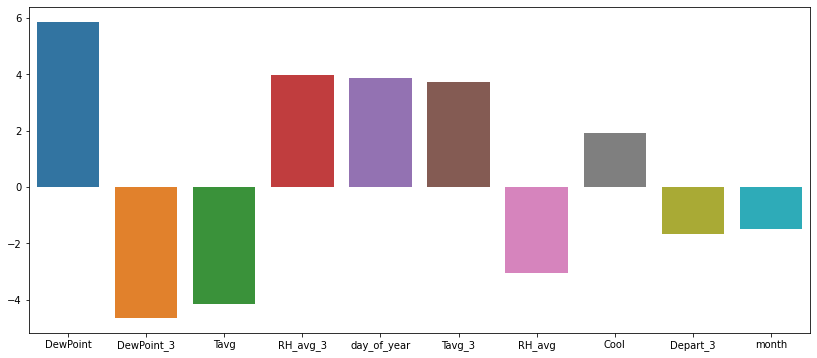

In [29]:
best_log_reg.fit(resample_X_train, resample_y_train)

f_importance = pd.Series(index=undersample_X_train.columns.values, data = best_log_reg.get_params()['log_reg'].coef_[0,:])

abs_f_importance = np.abs(f_importance).sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=abs_f_importance.index[:10], y=f_importance[abs_f_importance.index[:10]])
plt.show()

In [30]:
y_pred = best_log_reg.predict(X_test)

cm = confusion_matrix(y_test.values, y_pred, labels=[0,1], normalize='pred')
print(cm)

print(classification_report(y_test.values, y_pred))

[[0.98512508 0.85874799]
 [0.01487492 0.14125201]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1992
           1       0.14      0.80      0.24       110

    accuracy                           0.74      2102
   macro avg       0.56      0.77      0.54      2102
weighted avg       0.94      0.74      0.81      2102

